# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

## Volatility modeling and its effect on pricing European call options

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [45]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import math
from scipy.stats import norm
from scipy.stats import skew

Some Black-Scholes functions that we will need later:

In [46]:

def bs_call_delta(S0, K, sigma, t, r):
    """
    Returns the Delta (sensitivity to spot price) of a European call option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Call Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1)

def bs_call(S0, K, sigma, t, r = 0):
    """
    Computes the Black-Scholes price of a European call option.

    Parameters:
        S0 (float): Current asset price
        K (float): Strike price
        sigma (float): Annualized volatility (standard deviation of log returns)
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate (annualized)

    Returns:
        float: Call option price
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    call_price = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    return call_price

In [47]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

# Annotations begin here:

I am going to use a GARCH(1,1) model to simulate the volatility. GARCH stands for Generalized Autoregressive Conditional Heteroskedasticity. It can be thought of as a simple generalization of the Geometric Brownian motion used so far to model stock movement, where the volatility $\sigma_t$ varies with time. 
It is used widely in the industry to describe and forecast financial market volatility. 

In the GARCH(1,1) model used here, the dynamics of volatility is quite simple. It assumes that today's variance depends on both yesterday's squared return (ARCH term) and yesterday's variance (GARCH term), capturing volatility clustering and autoregression commonly observed in financial data. 


If $r_t$ denotes the log-return at time-t, the GARCH(1,1) model is specified by
$$S_t = S_{t-dt}e^{r_t}$$
$$r_t = \left(r + \mu - \frac{1}{2}\sigma_t^2\right)dt + \epsilon_t$$
$$\epsilon_t = \sigma_t z_t\sqrt{dt}$$
$$\sigma_t^2 = \alpha_0 + \alpha_1\epsilon_{t-1}^2 + \beta_1\sigma_{t-1}^2$$


where $z_t \sim \mathcal{N}(0,1)$

In the equation for the variance, 
- $\alpha_0$ controls the long-run average variance; it's the baseline volatility level.
- $\alpha_1$ measures the impact of recent shocks; higher $\alpha_1$ means volatility reacts strongly to new information.
- $\beta$ captures the persistence of volatility; higher $\beta$ means volatility decays slowly after a shock.

In the code below, we can set $\alpha_1 = \beta_1 = 0$ at any point to go bach to Geometric Brownian Motion.

In [48]:
def GARCH_stock_path(S0, t, r, mu, sigma_coeffs, n_paths, n_steps):
    '''
    Generation of custom stock paths following where the volatility is modeled using 
    a GARCH(1,1) model
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    sigma_coeffs (tuple): parameters of the GARCH(1,1) model, (alpha_0, alpha_1, beta_1) respectively
    
    Returns:
    
    Simulated stock paths and sigmas
    '''
    [alpha0, alpha1, beta1] = sigma_coeffs
    sigma_inf = np.sqrt(alpha0/(1 - alpha1 - beta1))
    
    # #Noise in volatility
    # noise = np.random.normal(0,1,size = (n_paths, n_steps))

    #Time increment between each step
    dt = t/n_steps

    # Allocate arrays
    sigma2 = np.zeros((n_paths, n_steps))
    sigma2[:, 0] = sigma_inf**2
    epsilon = np.random.normal(0,1, size=(n_paths,n_steps))

    # Loop over time to calculate volatilities
    for t in range(1, n_steps):
        sigma2[:, t] = alpha0 + alpha1 * epsilon[:, t-1]**2 + beta1 * sigma2[:, t-1]
    
    sigma = np.sqrt(sigma2)
    #log-returns between each step
    increments = (mu + r - 0.5*sigma2)*dt + epsilon*sigma*np.sqrt(dt)
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)

    #paths
    paths = S0*np.exp(log_returns)
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    return sigma, paths
    

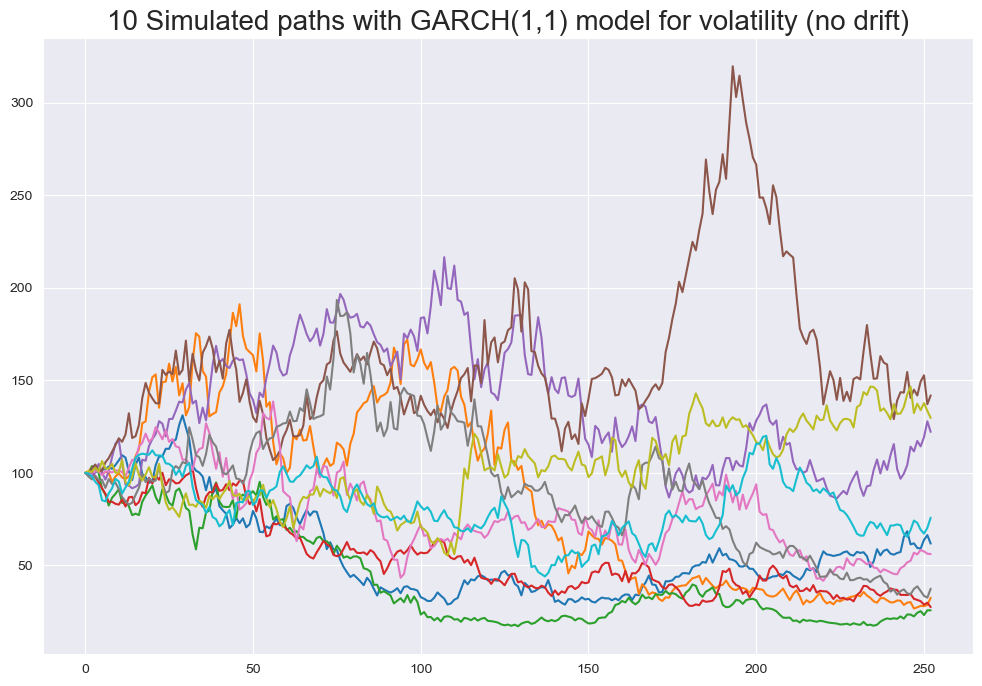

In [49]:
S0 = 100
t = 2
r = 0.039
mu = 0.0
n_paths = 10
n_steps = 252
alpha_1 = 0.05
beta_1 = 0.9
#Asymptotic value of volatility
sigma_inf = 0.1
sigma_coeffs = [(sigma_inf**2)*(1 - alpha_1 - beta_1), alpha_1, beta_1]


simulated_sigmas, simulated_paths = GARCH_stock_path(S0, t, r, mu, sigma_coeffs,  n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated paths with GARCH(1,1) model for volatility (no drift)', size = 20)


plt.show()

simulated_log_returns = np.log(simulated_paths[:, 1:] / simulated_paths[:, :-1])

Simulate 500 paths

In [50]:
simulated_sigmas, simulated_paths = GARCH_stock_path(S0, t, r, mu, sigma_coeffs,  500, n_steps)
simulated_log_returns = np.log(simulated_paths[:, 1:] / simulated_paths[:, :-1])

Function to calculate rolling volatility from a numpy array of log-returns

In [51]:
def rolling_volatility(log_returns, window=30):
    """
    Compute rolling volatility over a window (in days) for multiple paths using pandas.
    
    Parameters:
    - log_returns: np.ndarray of shape (n_paths, n_steps)
    - window: int, rolling window size (e.g., 30)
    - annualize: bool, whether to scale by sqrt(252)
    
    Returns:
    - vol: np.ndarray of shape (n_paths, n_steps), NaN-padded
    """
    n_paths, n_steps = log_returns.shape
    vol = np.full((n_paths, n_steps), np.nan)  # initialize with NaNs

    for i in range(n_paths):
        series = pd.Series(log_returns[i])
        rolling_std = np.sqrt(252)*series.rolling(window=window).std(ddof=1)
        vol[i] = rolling_std.values

    return vol

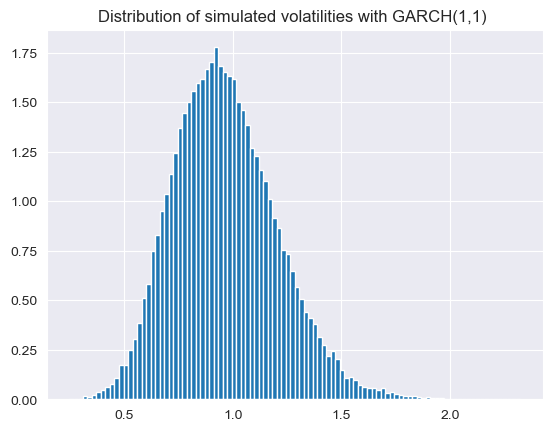

2.323777572406058 0.2477367325220419


In [52]:
temp = rolling_volatility(simulated_log_returns, 24)
#cleanup (remove NaNs)
vols = np.array([temp[i][~np.isnan(temp[i])] for i in range(len(temp))])
#Plot histogram of volatilities
plt.hist(vols.flatten(), bins=100, density =True)
plt.title("Distribution of simulated volatilities with GARCH(1,1) ")
plt.show()
print(np.max(vols), np.min(vols))

We can see that the volatility distributions are skewed, but not skewed enough as seen from market data. Perhaps running an optimizer to fit the parameters would yield an appropriately skewed distribution with fatter tails.

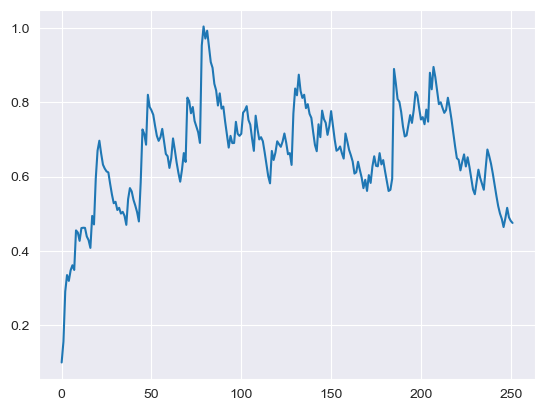

In [53]:
plt.plot(simulated_sigmas[4])

Next, I am going to write one more model to simulate the volatility of a stock, exponential-GARCH or EGARCH(1,1). EGARCH(1,1) is an extension of the GARCH model that allows for asymmetric effects of shocks on volatility. Unlike standard GARCH, EGARCH models the logarithm of the variance, ensuring that volatility forecasts remain positive without requiring parameter constraints. This model captures the leverage effect—where negative shocks tend to increase volatility more than positive shocks of the same magnitude—making it particularly useful for modeling financial returns where asymmetry is common.


The EGARCH(1,1) model expresses the logarithm of the conditional variance as:

$$
\ln(\sigma_t^2) = \omega + \beta \ln(\sigma_{t-1}^2) + \alpha \left(|z_{t-1}| - \mathbb{E}[|z|]\right) + \gamma \left( z_{t-1} \right)
$$
where $z_t \sim \mathcal{N}(0,1)$.

The parameters $(\omega, \alpha,\beta, \gamma)$ have the following interpretations:

- $\omega$: long-term average log variance  
- $\beta$: persistence of volatility  
- $\alpha$: magnitude effect of shocks (symmetric)  
- $\gamma$: asymmetry or leverage effect (captures how negative vs positive shocks impact volatility)


In [54]:
def EGARCH_stock_path(S0, t, r, mu, egarch_params, n_paths, n_steps):
    '''
    Generation of stock paths following where the volatility is modeled using 
    a EGARCH(1,1) model
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    egarch_params (tuple): (omega, alpha, beta, gamma)
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simulatled stock paths and sigmas
    '''
    omega, alpha, beta, gamma = egarch_params

    #Time increment between each step
    dt = t/n_steps

    # Constant for E[|Z|] where Z ~ N(0,1)
    E_abs_eps = np.sqrt(2 / np.pi)

    # Allocate arrays
    log_sigma2 = np.zeros((n_paths, n_steps))
    sigma = np.zeros((n_paths, n_steps))
    epsilon = np.zeros((n_paths, n_steps))
    log_sigma2[:, 0] = omega/(1 - beta)
    sigma[:, 0] = np.exp(0.5 * log_sigma2[:, 0])
    epsilon[:, 0] = np.random.normal(0,1, size=n_paths)

    # Loop over time to calculate volatilities
    for t in range(1, n_steps):
        log_sigma2[:, t] = omega + beta * log_sigma2[:, t-1] + gamma*epsilon[:, t-1] + alpha * (np.abs(epsilon[:, t-1]) - E_abs_eps)
        sigma[:, t] = np.exp(0.5*log_sigma2[:, t])
        epsilon[:, t] = np.random.normal(0,1,size=n_paths)    
 
    
    #log-returns between each step
    increments = ((mu + r - 0.5 * sigma**2) * dt) + (sigma * np.sqrt(dt) * epsilon)
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    #paths
    paths = S0*np.exp(log_returns)
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return sigma, paths

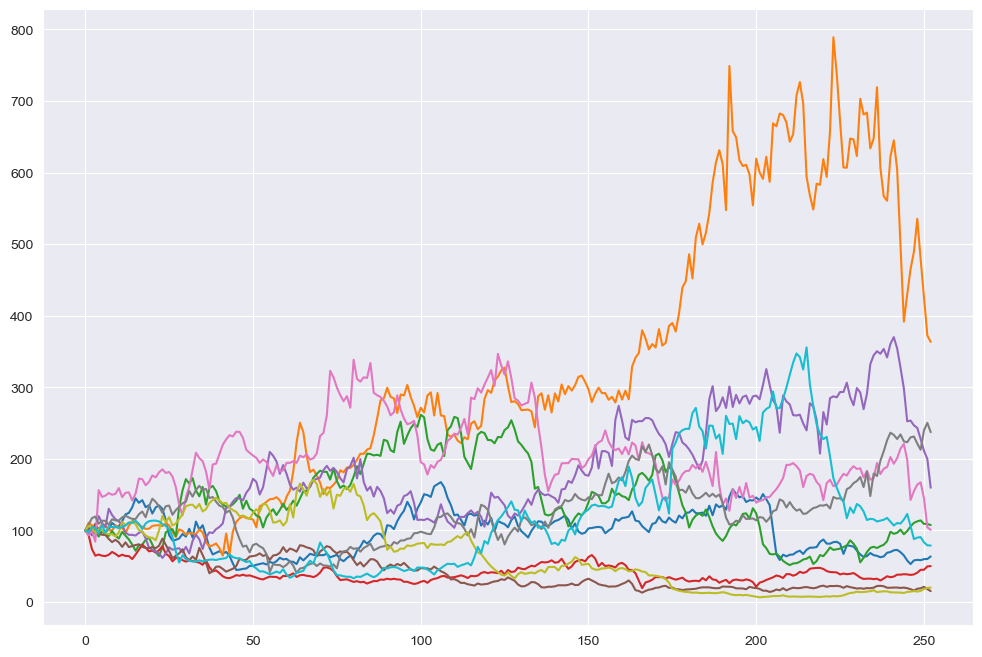

In [55]:

S0 = 100
t = 2
r = 0.039
mu = 0.0
n_paths = 10
n_steps = 252
# egarch_params = [ -0.2, 0.5, 0.9, -0.15 ]
egarch_params = [-0.3,0.97,0.25,-0.3]


simulated_sigmas, simulated_paths = EGARCH_stock_path(S0, t, r, mu, egarch_params,  n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
# plt.title(f'{n_paths} Simulated paths with EGARCH(1,1) model for volatility', size = 20)


plt.show()

simulated_log_returns = np.log(simulated_paths[:, 1:] / simulated_paths[:, :-1])

We see that the stock price under EGARCH(1,1) can spike a lot despite having 0 drift

In [56]:
simulated_sigmas, simulated_paths = EGARCH_stock_path(S0, t, r, mu, egarch_params,  500, n_steps)
simulated_log_returns = np.log(simulated_paths[:, 1:] / simulated_paths[:, :-1])

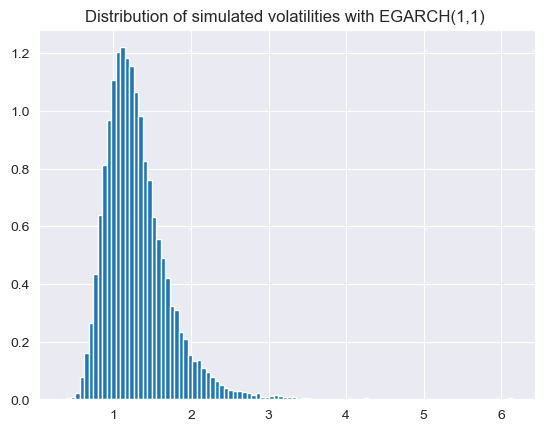

6.146124874512281 0.33187419959965325


In [57]:
temp = rolling_volatility(simulated_log_returns, 24)
#cleanup (remove NaNs)
vols = np.array([temp[i][~np.isnan(temp[i])] for i in range(len(temp))])
#Plot histogram of volatilities
plt.hist(vols.flatten(), bins=100, density =True)
plt.title("Distribution of simulated volatilities with EGARCH(1,1) ")
plt.show()
print(np.max(vols), np.min(vols))

Immediately, we see a much better skewness and similarity to the histogram we saw for the SPY index in the lecture notebooks.

Text(0.5, 0, 'Number of days')

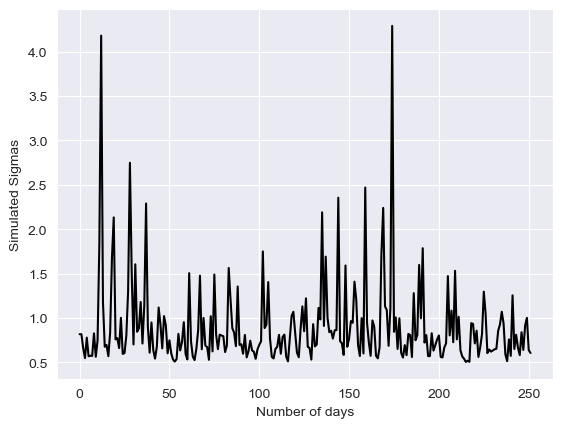

In [58]:
plt.plot(simulated_sigmas[4], color = 'black')
plt.ylabel('Simulated Sigmas')
plt.xlabel('Number of days')

## Effect of non-constant $\sigma$ on hedging profits

Hereon, we will compare the effects of the non-constant volatility on $\Delta$-hedged profits. For this, below is a giant function that takes in all the parameters in the world, and calculates $\Delta$ hedging profits. 

The function below takes a "stock_path_generator" callable, that should return (simulated_sigmas, simulated_paths). Essentially I wrote this function to work for both our GARCH(1,1) simulator and the EGARCH(1,1) simulator above. It also has a feature called "constant_sigma" which, when set to True, the $\Delta$'s are calculated with the _average_ $\sigma$ returned fromt he stock_path_generator, instead of using the correctly simulated volatilities. This allows us to investigate the effects of assuming a constant volatility when $\Delta$-hedging when the underlying stock movement does not exhibit constant volatility.

The hedging-strategy is $\Delta$-hedging, where the $\Delta$ s are calculated at each hedging step using the Black-Scholes formula albeit with time-dependent $\sigma$'s. 

Finally, it assumes 100 options are sold. 

In [59]:
def simulate_delta_hedged_profits(S0, K, P, t, r, mu, n_steps, n_paths, n_hedges, stock_path_generator, params, constant_sigma= False):
    """
    Simulate delta-hedged profits for a European call option seller using 
    discrete-time hedging under a specified stock path model.

    Parameters
    ----------
    S0 : float,     Initial stock price.

    K : float,      Strike price of the European call option.

    P : float,      Price at which premium is sold, in units of black-scholes premium (P = 1 is BS price).

    t : float,      Time to expiration in years (e.g., 1.0 = 1 year).

    r : float,      Risk-free interest rate (continuously compounded).

    mu : float,     Drift of the stock (not used in Black-Scholes hedging, but passed to the path generator).

    n_steps : int,  Total number of time steps for the simulation (e.g., 252 for daily over 1 year).

    n_paths : int,  Number of Monte Carlo simulation paths.

    n_hedges : int, Number of times the portfolio is re-hedged (equally spaced).

    stock_path_generator : callable
        Function that generates stock price paths and corresponding volatility paths.
        Must return a tuple:
            (simulated_sigmas, simulated_paths)
        where both are NumPy arrays of shape (n_paths, n_steps).

    params : dict
        Dictionary of parameters to be passed into the stock_path_generator.

    constant_sigma : bool, optional
        If True, replaces each path's volatility with its average over time, simulating
        delta hedging under the assumption of constant volatility. Default is False.

    Returns
    -------
    profits_hedged : np.ndarray
        Array of length `n_paths` representing the total profit (or loss) for each path
        of the delta-hedged option seller at maturity.
    """

    dt = t/n_steps
    hedge_days =  np.linspace(0, n_steps - 1, n_hedges, dtype=int)
        
    simulated_sigmas, simulated_paths = stock_path_generator(S0, t, r, mu, params, n_paths, n_steps)
    avg_sigmas = np.mean(simulated_sigmas, axis=1)
    # print(avg_sigmas)

    if constant_sigma:
        simulated_sigmas = np.tile(avg_sigmas[:,None], (1, n_steps))
        
    sold_premiums = bs_call(S0, K, avg_sigmas, t, r)*P*100
    call_payouts = np.exp(-r*t)*np.maximum(simulated_paths[:, -1] - K, 0)
    deltas = bs_call_delta(S0, K, avg_sigmas, t, r)
    
    stock_profits = []
    
    for i in range(1, len(hedge_days)):
        stock_end = simulated_paths[:, hedge_days[i]]
        stock_start = simulated_paths[:, hedge_days[i-1]]
        stock_profit = (stock_end - stock_start*np.exp(r*(hedge_days[i] - hedge_days[i-1])*dt))*deltas*np.exp(-r*hedge_days[i]*dt)
        stock_profits.append(stock_profit)
        tte = t - hedge_days[i]*dt
        sigma_step = simulated_sigmas[:, hedge_days[i]]
        deltas = bs_call_delta(stock_end, K, sigma_step, tte, r)

    if hedge_days[-1] < n_steps:
        final_liquidation = (simulated_paths[:,-1] - simulated_paths[:, hedge_days[-1]]*np.exp(r*dt*(n_steps - hedge_days[-1])))*np.exp(-r*t)
        stock_profits.append(final_liquidation)

    total_stock_profit = np.sum(stock_profits, axis=0) if len(stock_profits) else np.zeros(n_paths)
    profits_hedged = sold_premiums + total_stock_profit - call_payouts
    return profits_hedged


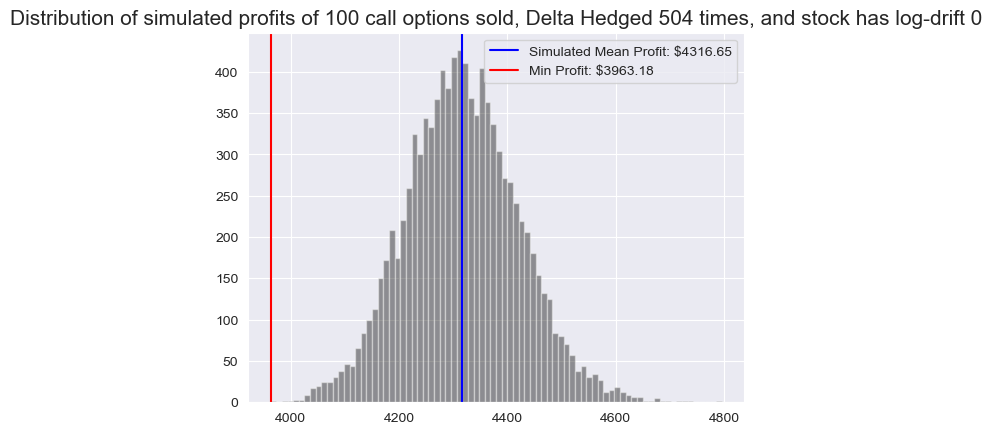

In [60]:
S0= 100
K = 120
P = 1
t = 2
r = 0.039
mu = 0
n_steps = 252*2
n_paths = 10000
n_hedges = 252*2

profits_hedged = simulate_delta_hedged_profits(S0, K, P, t, r, mu, n_steps, n_paths, n_hedges, EGARCH_stock_path, egarch_params, constant_sigma=False)
plt.hist(profits_hedged, bins = 80, alpha = .4, color = 'black')
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
plt.axvline(np.min(profits_hedged), label = f'Min Profit: ${np.min(profits_hedged):.2f}', color = 'red')
plt.title(f'Distribution of simulated profits of 100 call options sold, Delta Hedged {n_hedges} times, and stock has log-drift {mu}',size = 15)
plt.legend()
plt.show()

In [61]:
sigma_coeffs = [0.2, 0.0,0]
hedging_numbers = [2, 5, 10,20,30,40,50,60,70,80,90,100,150,200,252, 504]
metrics = []

for n_hedges in hedging_numbers:
    profits_hedged = simulate_delta_hedged_profits(S0, K, P, t, r, mu, n_steps, n_paths, n_hedges, EGARCH_stock_path, egarch_params, constant_sigma=False)
    profits_hedged_static_sigma = simulate_delta_hedged_profits(S0, K, P, t, r, mu, n_steps, n_paths, n_hedges, EGARCH_stock_path, egarch_params, constant_sigma=True)

    VaR_5 = np.percentile(profits_hedged, 5)
    VaR_5_static = np.percentile(profits_hedged_static_sigma, 5)

    #Compute distribution metrics for both cases
    row = {
        "max_loss": np.min(profits_hedged),
        "avg_profit": np.average(profits_hedged),
        "std": np.std(profits_hedged),
        "skew": skew(profits_hedged),
        "VaR_5": VaR_5,
        "CVaR_5": profits_hedged[profits_hedged <= VaR_5].mean(),
        "static_sigma": False
    }
    
    row2 = {
        "max_loss": np.min(profits_hedged_static_sigma),
        "avg_profit": np.average(profits_hedged_static_sigma),
        "std": np.std(profits_hedged_static_sigma),
        "skew": skew(profits_hedged_static_sigma),
        "VaR_5": VaR_5_static,
        "CVaR_5": profits_hedged_static_sigma[profits_hedged_static_sigma <= VaR_5_static].mean(),
        "static_sigma": True
    }
    metrics.append(row)
    metrics.append(row2)

    del profits_hedged, profits_hedged_static_sigma

In [62]:
import pandas as pd

metrics_df = pd.DataFrame(metrics)

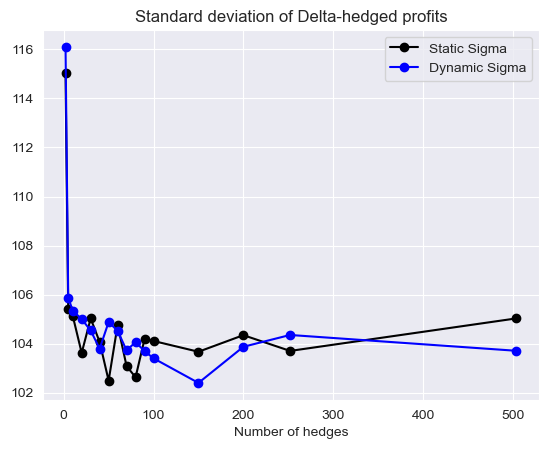

In [63]:
plt.plot(hedging_numbers, metrics_df[metrics_df["static_sigma"] == True]['std'], color = 'black', marker = 'o', label='Static Sigma')
plt.plot(hedging_numbers, metrics_df[metrics_df["static_sigma"] == False]['std'], color='blue', marker='o', label='Dynamic Sigma')
plt.xlabel('Number of hedges')
plt.title('Standard deviation of Delta-hedged profits')
plt.legend()
plt.show()

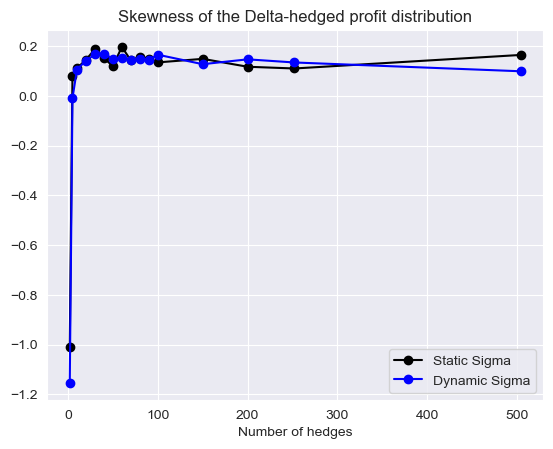

In [64]:
plt.plot(hedging_numbers, metrics_df[metrics_df["static_sigma"] == True]['skew'], color = 'black', marker = 'o', label='Static Sigma')
plt.plot(hedging_numbers, metrics_df[metrics_df["static_sigma"] == False]['skew'], color='blue', marker='o', label='Dynamic Sigma')
plt.title('Skewness of the Delta-hedged profit distribution')
plt.xlabel('Number of hedges')
plt.legend()
plt.show()

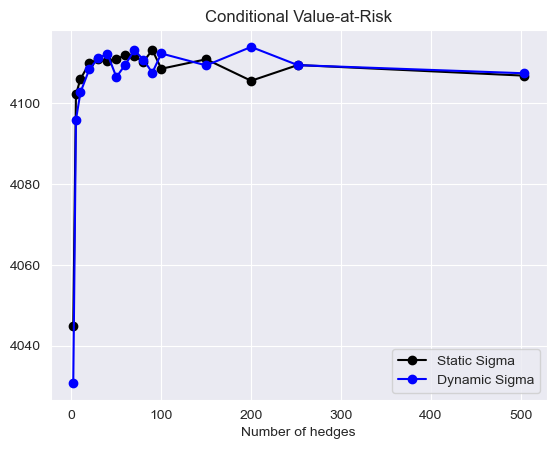

In [65]:
plt.plot(hedging_numbers, metrics_df[metrics_df["static_sigma"] == True]['CVaR_5'], color = 'black', marker = 'o', label='Static Sigma')
plt.plot(hedging_numbers, metrics_df[metrics_df["static_sigma"] == False]['CVaR_5'], color='blue', marker='o', label='Dynamic Sigma')
plt.title('Conditional Value-at-Risk')
plt.xlabel('Number of hedges')
plt.legend()
plt.show()

### For the chosen models and parameters, we derive the conclusion that the non-constant $\sigma$ does not cause significant changes to the distribution of the profits that are gained by selling call-options and $\Delta$-hedging. 



### Why is that?

I suppose this is because volatility is erratic, but also mean-reverting. If you do not hedge *constantly*, it is almost sure that the spikes in volatility will be incommensurate with the times when the hedging is performed. Moreover, we know that volatility is mean reverting, thus it has a tendency of returning to its long term value immediately after spikes. Hence, the hedging profits do not increase measurably by fitting the volatility. 

This makes it clear that $\Delta$-hedging is much, much more important than volatility modeling for call-option pricing. For other derivatives, it is possible that the volatility model is crucial. However for a simple derivative like European call options, the dependence on $S_0$ is much more than on $\sigma$, so for all practical purposes one can neglect the effect of non-constant volatility while pricing European options.